# Task

We will use the SAC algorithm to train the **walker** environment.

You can implement it yourself or use the Stablebaselines3 version.

Walker environment consists of a structure of legs and the agent's actions can move the joints. The goal is to make the structure able to walk.

You can see more about the actions, observations and rewards [here](https://gymnasium.farama.org/environments/mujoco/walker2d/)

![Walker Image](https://gymnasium.farama.org/_images/walker2d.gif)


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.9     |
|    ep_rew_mean     | 122      |
| time/              |          |
|    episodes        | 10       |
|    fps             | 23       |
|    time_elapsed    | 10       |
|    total_timesteps | 239      |
| train/             |          |
|    actor_loss      | -78.1    |
|    critic_loss     | 31.7     |
|    ent_coef        | 0.944    |
|    ent_coef_loss   | -1.59    |
|    learning_rate   | 0.0001   |
|    n_updates       | 552      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.2     |
|    ep_rew_mean     | 132      |
| time/              |          |
|    episodes        | 20       |
|    fps             | 17       |
|    time_elapsed    | 30       |
|    total_timesteps | 525      |
| train/             |          |
|    actor_loss      | -162   

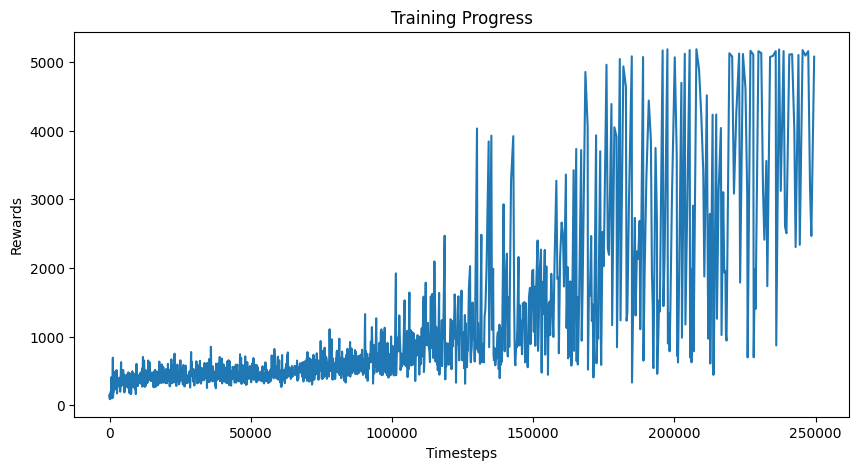

In [16]:
# Import necessary libraries
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os

# Create a folder to save logs
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create the Humanoid environment and wrap it in a Monitor wrapper
env = gym.make("Humanoid-v4", render_mode="rgb_array")
env = Monitor(env, log_dir)

# Set up the hyperparameters
sac_hyperparams = {
    'learning_rate': 1e-4,
    'buffer_size': 200000,
    'batch_size': 128,
    'gamma': 0.997, #0.98,
    'tau': 0.01,
    'train_freq': (1, 'step'), # 1
    'gradient_steps': 4,
    'policy_kwargs': dict(net_arch=[400, 300]),
    'ent_coef': 'auto'  # Using automatic entropy tuning
}

# Initialize the SAC model with the environment and custom hyperparameters
model = SAC("MlpPolicy", env, verbose=1, **sac_hyperparams)

# Train the model
model.learn(total_timesteps=250000, log_interval=10)

# Save the trained model
model.save("sac_humanoid")

# Function to plot training progress
def plot_results(log_folder):
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    plt.figure(figsize=(10, 5))
    plt.plot(x, y)
    plt.xlabel('Timesteps')
    plt.ylabel('Rewards')
    plt.title('Training Progress')
    plt.show()

# Plot the training progress
plot_results(log_dir)

# Delete the model to demonstrate loading
del model

# Load the saved model
model = SAC.load("sac_humanoid")

# Reset the environment
obs, info = env.reset()

# Create a list to store frames
frames = []

# Run the model in the environment
for _ in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    
    # Capture the current frame
    frame = env.render()
    frames.append(frame)
    
    if terminated or truncated:
        obs, info = env.reset()

# Save frames as a video
video_filename = 'humanoid_sac.mp4'
imageio.mimsave(video_filename, [np.array(frame) for frame in frames], fps=30)
